In [1]:
import gym
import gym_sokoban
import torch
import numpy as np
import matplotlib.pyplot as plt

import data
from elements import TinyWorldElements as elem

## Interacting with gym-sokoban

In [2]:
env = gym.make("Sokoban-small-v1")
env.seed(0)
env.reset(render_mode="tiny_rgb_array")

array([[[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [243, 248, 238],
        [142, 121,  56],
        [243, 248, 238],
        [254, 126, 125],
        [243, 248, 238],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [254, 126, 125],
        [243, 248, 238],
        [243, 248, 238],
        [142, 121,  56],
        [243, 248, 238],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [254, 126, 125],
        [243, 248, 238],
        [243, 248, 238],
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [243, 248, 238],
        [142, 121,  56],
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [243, 248, 238],
        [160, 212,  56],
        [  0,   0,   0],
        [  0,  

In [3]:
def show_grids():
    fix, axes = plt.subplots(1, 2)
    axes[0].imshow(env.render("rgb_array"))
    axes[1].imshow(env.render("tiny_rgb_array"))

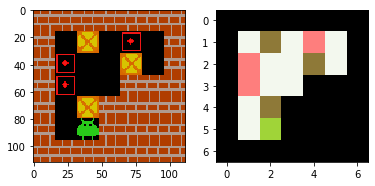

In [4]:
show_grids()

Available actions:

In [5]:
env.get_action_lookup()

{0: 'no operation',
 1: 'push up',
 2: 'push down',
 3: 'push left',
 4: 'push right',
 5: 'move up',
 6: 'move down',
 7: 'move left',
 8: 'move right'}

Reward:  -0.1


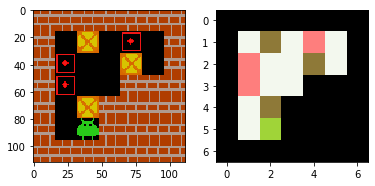

In [6]:
# Do nothing
observation, reward, done, info = env.step(0)
print("Reward: ", reward)
show_grids()

Reward:  -0.1


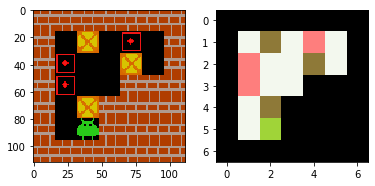

In [7]:
# Move right
observation, reward, done, info = env.step(8)
print("Reward: ", reward)
show_grids()

Moving to right doesn't do anything when the path is blocked

Reward:  -0.1


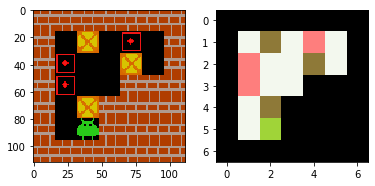

In [8]:
# Push right
observation, reward, done, info = env.step(4)
print("Reward: ", reward)
show_grids()

Yay! Finally some action. We get a reward.

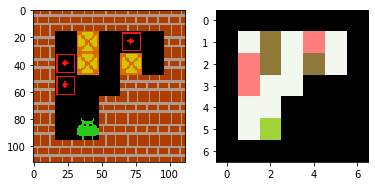

In [9]:
env.step(6) # DOWN
env.step(8) # RIGHT
env.step(1) # PUSH UP
env.step(1) # PUSH UP
env.step(1) # PUSH UP
env.step(1) # PUSH UP
env.step(6) # DOWN
env.step(6) # DOWN
env.step(6) # DOWN
env.step(6) # DOWN
show_grids()

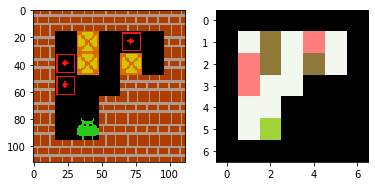

In [10]:
observation, reward, done, info = env.step(8) # RIGHT
show_grids()

In [11]:
done

False

done is False, but this puzzle is unsolvable.

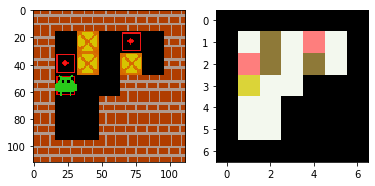

In [12]:
env.step(1) # PUSH UP
env.step(1) # PUSH UP
env.step(1) # PUSH UP
env.step(1) # PUSH UP
env.step(3) # PUSH LEFT
env.step(3) # PUSH LEFT
env.step(3) # PUSH LEFT
env.step(3) # PUSH LEFT
show_grids()

In [13]:
observation, reward, done, info = env.step(0)

In [14]:
done

False

Ideas:
- maximum number of steps. Must be adapted to difficulty, or even learning stage...
- check if a push has been done in last N steps (same issues)

## Constructing a graph from the pixels

### Minimal embedding

In [15]:
pixels_state = env.reset(render_mode="tiny_rgb_array")
# All neighbors connected
G = data.pixels2graph(pixels_state, data.embedding_minimal, data.linker_neighbors)

In [16]:
import networkx as nx
from torch_geometric.utils.convert import to_networkx

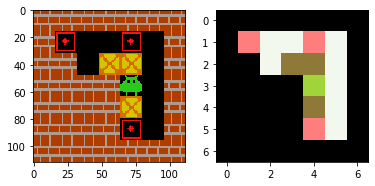

In [17]:
show_grids()

In [55]:
def show_graph_nx(graph_nx, node_color, pos_map, title=""):
    plt.figure(1, figsize=(7,7)) 
    plt.title(title)
    nx.draw(graph_nx, cmap=plt.get_cmap('seismic'), node_color=node_color, node_size=75, linewidths=6, pos=pos_map)    

In [51]:
G_nx = to_networkx(G)
pos_map = {i: pos for i, pos in enumerate(G.pos)}

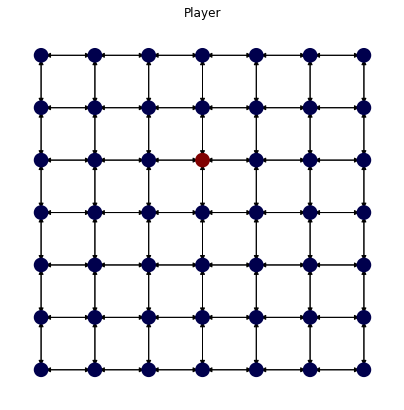

In [56]:
node_feature = G.x[:, 1] # has_player
show_graph_nx(G_nx, node_feature, pos_map, "Player")

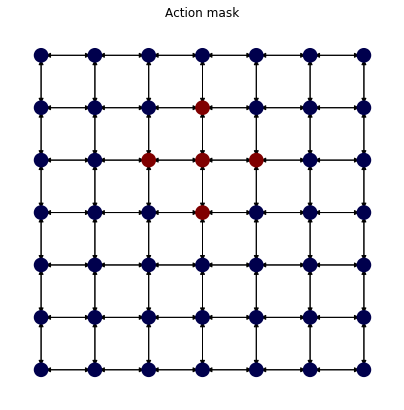

In [57]:
node_feature = G.mask # action mask
show_graph_nx(G_nx, node_feature, pos_map, "Action mask")

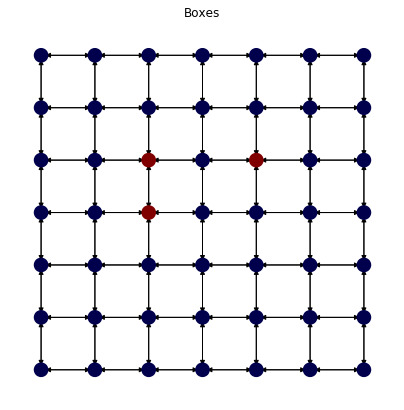

In [58]:
node_feature = G.x[:, 0] # box
show_graph_nx(G_nx, node_feature, pos_map, "Boxes")

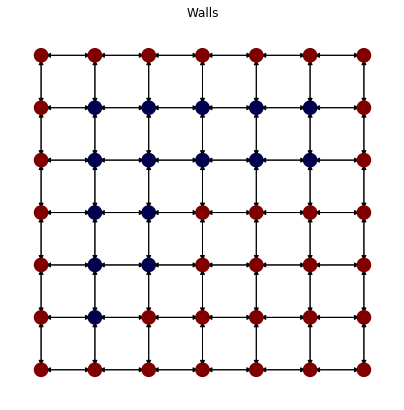

In [59]:
node_feature = G.x[:, 3] # wall
show_graph_nx(G_nx, node_feature, pos_map, "Walls")

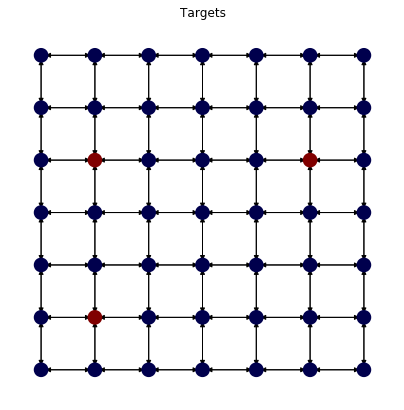

In [60]:
node_feature = G.x[:, 2] # targets
show_graph_nx(G_nx, node_feature, pos_map, "Targets")

### Removing wall-wall links

In [25]:
Gw = data.pixels2graph(pixels_state, data.embedding_minimal, data.linker_neighbors_remove_walls)
Gw_nx = to_networkx(Gw)
pos_map_w = {i: pos for i, pos in enumerate(Gw.pos)}

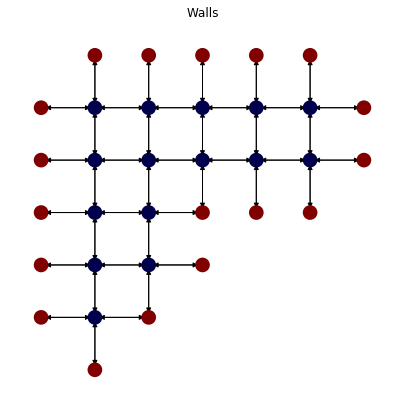

In [61]:
show_graph_nx(Gw_nx, Gw.x[:, 3], pos_map_w, "Walls")

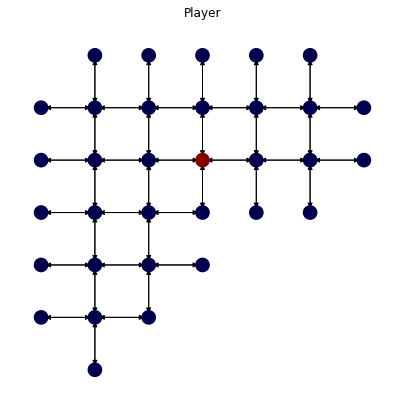

In [64]:
show_graph_nx(Gw_nx, Gw.x[:, 1], pos_map_w, "Player")

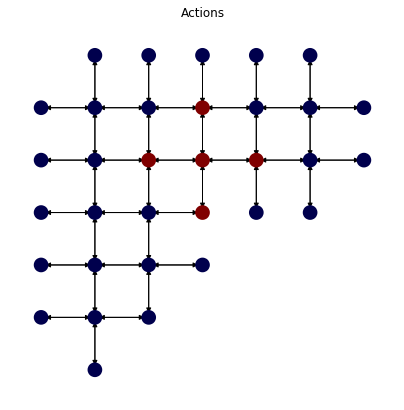

In [65]:
show_graph_nx(Gw_nx, Gw.mask, pos_map_w, "Actions")

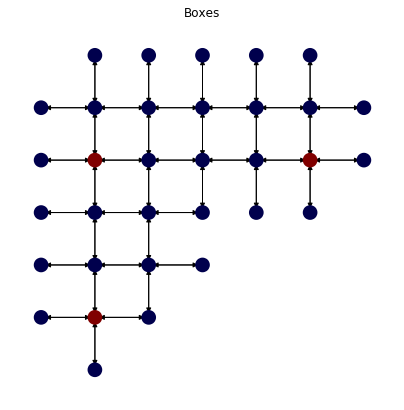

In [66]:
show_graph_nx(Gw_nx, Gw.x[:, 2], pos_map_w, "Boxes")